<a href="https://colab.research.google.com/github/evril7490/test/blob/master/Regression_EDA_ModelValuation_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.inspection import PartialDependenceDisplay

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

In [120]:
### Fill Na for categorical columns and continuous columns
def fill_na(df,category_cols=[], cont_cols=[],
            fill_category_value='unknown',
            fill_na_dict=None):
  X = df.copy()
  if not fill_na_dict:# we have not provided the fill_missing_dict
    fill_na_dict = {}
    for col in category_cols:
      fill_na_dict[col] = fill_category_value

    for col in cont_cols:
      fill_na_dict[col] = X[col].mean()

  for feat_col,fill_value in fill_na_dict.items():
    X[feat_col].fillna(fill_value,inplace=True)

  return X,fill_na_dict


def target_encoder(df,feat_cols,target_col,post_fix='_TE',target_encode_dict=None):
  df = df.copy()
  if not target_encode_dict:
    target_encode_dict = {}
    for col in feat_cols:
      target_encode_dict[col] = dict(df.groupby(col)[target_col].mean())
  for col in feat_cols:
    df[f'{col}{post_fix}'] = df[col].map(target_encode_dict[col])
  
  return df,target_encode_dict

def one_hot_encoder(df,feat_cols,enc_dict=None):
  enc_df = []
  # if enc_dict is not provided, will run the feats and create the encode dict
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = OneHotEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = enc
  
  for feat_col in feat_cols:
    enc = enc_dict[feat_col]
    enc_df.append( pd.DataFrame(enc.transform(df[[feat_col]]).toarray(),columns= [ f'{feat_col}_{k}' for k in enc.categories_[0] ],index=df.index ) )
  
  enc_df = pd.concat(enc_df,axis=1)
  for col in enc_df:
    if col in df:
      print(f'Will overwrite {col} since it already exist in df')
      df = df.drop(columns=[col])
  df = pd.concat([ df,enc_df], axis=1)
  return df,enc_dict

def label_encoder(df,feat_cols,enc_dict=None,postfix='_LE'):
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = LabelEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

  for feat_col in feat_cols:
    df[f'{feat_col}{postfix}'] = df[feat_col].map(enc_dict[feat_col])
  return df,enc_dict


def preprocess_test(test_df,preprocess_dict):
  df = test_df.copy()
  if 'fill_na_dict' in preprocess_dict:
    df,_ = fill_na(df,fill_na_dict=preprocess_dict['fill_na_dict'])

  if 'target_encode_dict' in preprocess_dict:
    feat_cols = preprocess_dict['target_encode_dict'].keys()
    df, _ = target_encoder(df,feat_cols,None,post_fix='_TE',target_encode_dict=preprocess_dict['target_encode_dict'])

  if 'one_hot_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['one_hot_enc_dict'].keys()
    df, _ = one_hot_encoder(df,feat_cols,enc_dict=preprocess_dict['one_hot_enc_dict'])
  
  if 'label_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['label_enc_dict'].keys()
    df, _ = label_encoder(df,feat_cols,enc_dict=preprocess_dict['label_enc_dict'])
  
  return df

In [137]:
def plot_feature_imp(classifier, feat_cols):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': feat_cols,
                                'Importance': np.round(classifier.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')
    importances.plot.barh(color='cadetblue',
                          edgecolor='firebrick',
                          legend=False,
                          figsize=(16,max(4,len(feat_cols)//2))
                          )
    plt.xlabel('Importance');
    return importances

In [187]:
def parameter_search(X,
                     y,
                     X_cv,
                     y_cv,
                     estimator,
                     param_grid,
                     ):
  best_score = np.inf
  for g in ParameterGrid(param_grid):
    estimator.set_params(**g)
    estimator.fit(X,y)
    # save if best
    y_cv_pred = estimator.predict(X_cv)
    err = ((y_cv_pred - y_cv)**2).mean()
    #print(oob_score,g)
    if err < best_score:
        best_score = err
        best_grid = g
  estimator.set_params(**best_grid)
  estimator.fit(X,y)
  r2= r2_score(y_cv,estimator.predict(X_cv))
  print(f"best rmse: {best_score:.4f} and r2 is {r2:.3f}, and para is {best_grid}") 
  return estimator


In [4]:
def upload_to_colab():
  from google.colab import files 
  import io
  uploaded = files.upload()
  f = list(uploaded.keys())[0]
  df = pd.read_csv(io.StringIO(uploaded[f].decode('utf-8')))
  return df

In [5]:
df_raw = upload_to_colab()

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume.csv


In [48]:
df_raw['date_time'].min(),df_raw['date_time'].max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [174]:
#categorizing hours to different time periods like morning, afternoon etc
def hour_modify(x):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [24,1,2,3]
    if x in Early_Morning:
        return 'Early_Morning'
    elif x in Morning:
        return 'Morning'
    elif x in Afternoon:
        return 'Afternoon'
    elif x in Evening:
        return 'Evening'
    elif x in Night:
        return 'Night'
    else:
        return 'Late_Night'

def cln_desc(x):
  x = x.lower()
  if 'clear' in x:
    return 'clear'
  if 'mist' in x or 'haze' in x or 'fog' in x : 
    return 'mist'
  if 'drizzle' in x or 'light rain' in x:
    return 'light rain'
  if 'snow' in x:
    return 'snow'
  if 'heavy' in x and 'rain' in x:
    return 'heavy rain'
  if 'thunder' in x:
    return 'thunder'
  return 'other'
def create_feat(train_df):
  train_df['date_time']     = pd.to_datetime(train_df['date_time'])
  train_df['hour']          = train_df['date_time'].dt.hour.map(hour_modify)
  train_df['isnot_holiday'] = (train_df['holiday']=='None').astype(int)
  train_df['weather']       = train_df['weather_description'].apply(cln_desc)
  train_df['day_of_week']   = train_df['date_time'].dt.dayofweek
  train_df['week_of_year']  = train_df['date_time'].dt.weekofyear
  train_df['day']= pd.to_datetime(train_df['date_time'].dt.date)
  train_df['hour']=train_df['date_time'].dt.hour
  train_df = train_df.merge(
          train_df.pivot(index='day',columns='hour',values='traffic_volume').shift(1).ffill().unstack().rename('tv_lag1').reset_index()).merge(
          train_df.pivot(index='day',columns='hour',values='traffic_volume').shift(7).ffill().unstack().rename('tv_lag7').reset_index())
  train_df = train_df[train_df['date_time']>='2013-01-01']
  return train_df

In [86]:
check = df_raw['date_time'].value_counts()
check[check>1]

2013-04-18 22:00:00    6
2013-05-19 10:00:00    6
2012-12-16 09:00:00    5
2012-10-26 04:00:00    5
2013-06-01 02:00:00    5
                      ..
2012-11-06 19:00:00    2
2015-10-12 13:00:00    2
2012-11-11 14:00:00    2
2017-08-17 13:00:00    2
2017-08-07 09:00:00    2
Name: date_time, Length: 5445, dtype: int64

In [87]:
df_raw[df_raw['date_time']=='2013-04-18 22:00:00']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,is_holiday
5249,None,274.79,0.0,0.0,90,Mist,mist,2013-04-18 22:00:00,1532,Night,False
5250,None,274.79,0.0,0.0,90,Drizzle,light intensity drizzle,2013-04-18 22:00:00,1532,Night,False
5251,None,274.79,0.0,0.0,90,Rain,light rain,2013-04-18 22:00:00,1532,Night,False
5252,None,274.79,0.0,0.0,90,Rain,moderate rain,2013-04-18 22:00:00,1532,Night,False
5253,None,274.79,0.0,0.0,90,Snow,heavy snow,2013-04-18 22:00:00,1532,Night,False
5254,None,274.79,0.0,0.0,90,Snow,snow,2013-04-18 22:00:00,1532,Night,False


In [175]:
df_raw = df_raw.drop_duplicates(subset=['date_time'],keep='first')

In [176]:
df_raw = create_feat(df_raw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [177]:
train_df =  df_raw[df_raw['date_time']<'2018-01-01'].reset_index(drop=True)
test_df  =  df_raw[df_raw['date_time']>='2018-01-01'].reset_index(drop=True)

In [178]:
TARGET='traffic_volume'

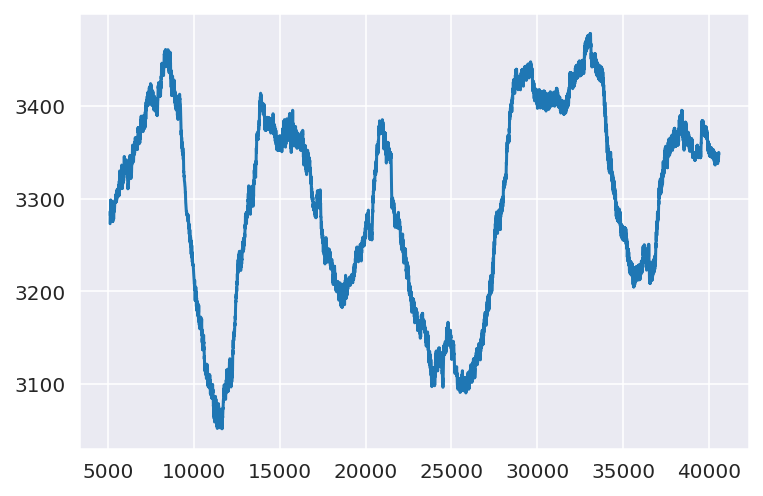

In [179]:
df_raw['traffic_volume'].rolling(window=126*24).mean().plot()

In [180]:
train_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,is_holiday,isnot_holiday,weather,day_of_week,week_of_year,day,tv_lag1,tv_lag7
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,0,True,0,other,1,1,2013-01-01,1195.0,803.0
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,1,False,1,other,1,1,2013-01-01,374.0,575.0
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,2,False,1,snow,1,1,2013-01-01,341.0,352.0
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,3,False,1,other,1,1,2013-01-01,295.0,191.0
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,4,False,1,other,1,1,2013-01-01,483.0,125.0


In [30]:
train_df['holiday'].value_counts()

None                         38511
Labor Day                        7
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        5
Thanksgiving Day                 5
Independence Day                 5
Washingtons Birthday             4
Veterans Day                     4
State Fair                       4
Memorial Day                     3
Columbus Day                     3
Name: holiday, dtype: int64

In [31]:
train_df['weather_main'].value_counts()

Clouds          12099
Clear           10718
Mist             4816
Rain             4541
Snow             2283
Drizzle          1423
Haze             1093
Thunderstorm      828
Fog               743
Smoke              16
Squall              3
Name: weather_main, dtype: int64

In [140]:
feats = ['temp','rain_1h','snow_1h','clouds_all','tv_lag1','tv_lag7','isnot_holiday','day_of_week','week_of_year','weather_clear', 'weather_heavy rain', 'weather_light rain',
       'weather_mist', 'weather_other', 'weather_snow', 'weather_thunder']

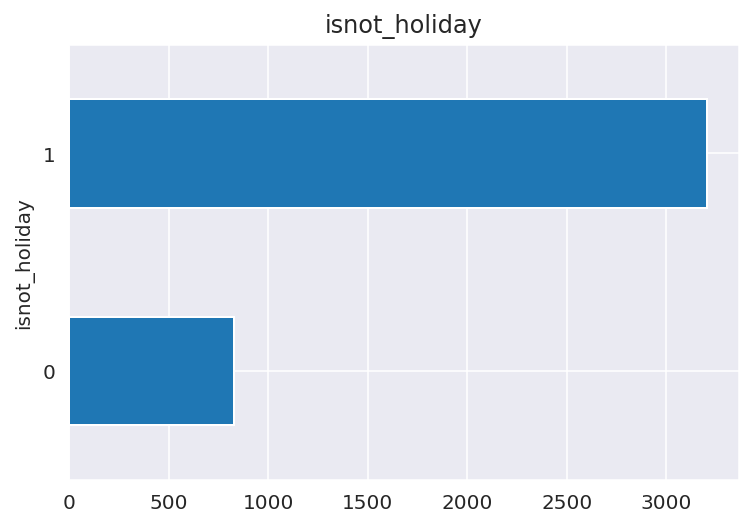

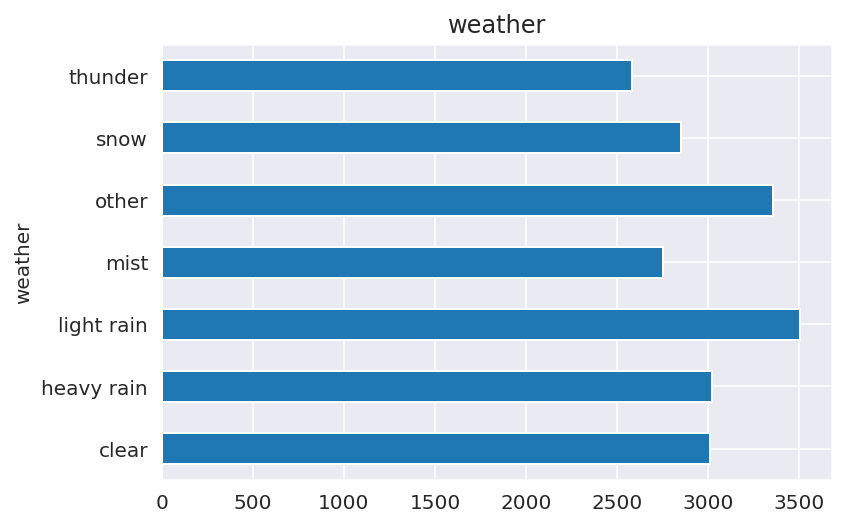

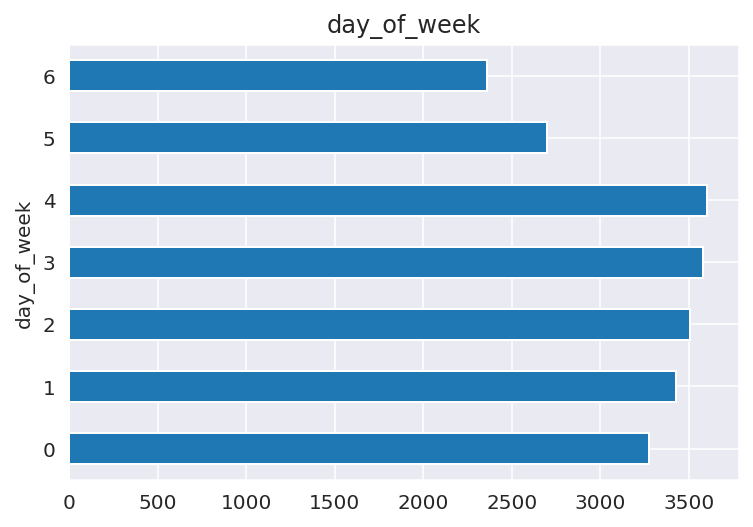

In [131]:

for feat_col in ['isnot_holiday','weather','day_of_week']:
    train_df.iloc[:24*365].groupby(feat_col)[TARGET].mean().plot(kind='barh',title=feat_col)
    plt.show()

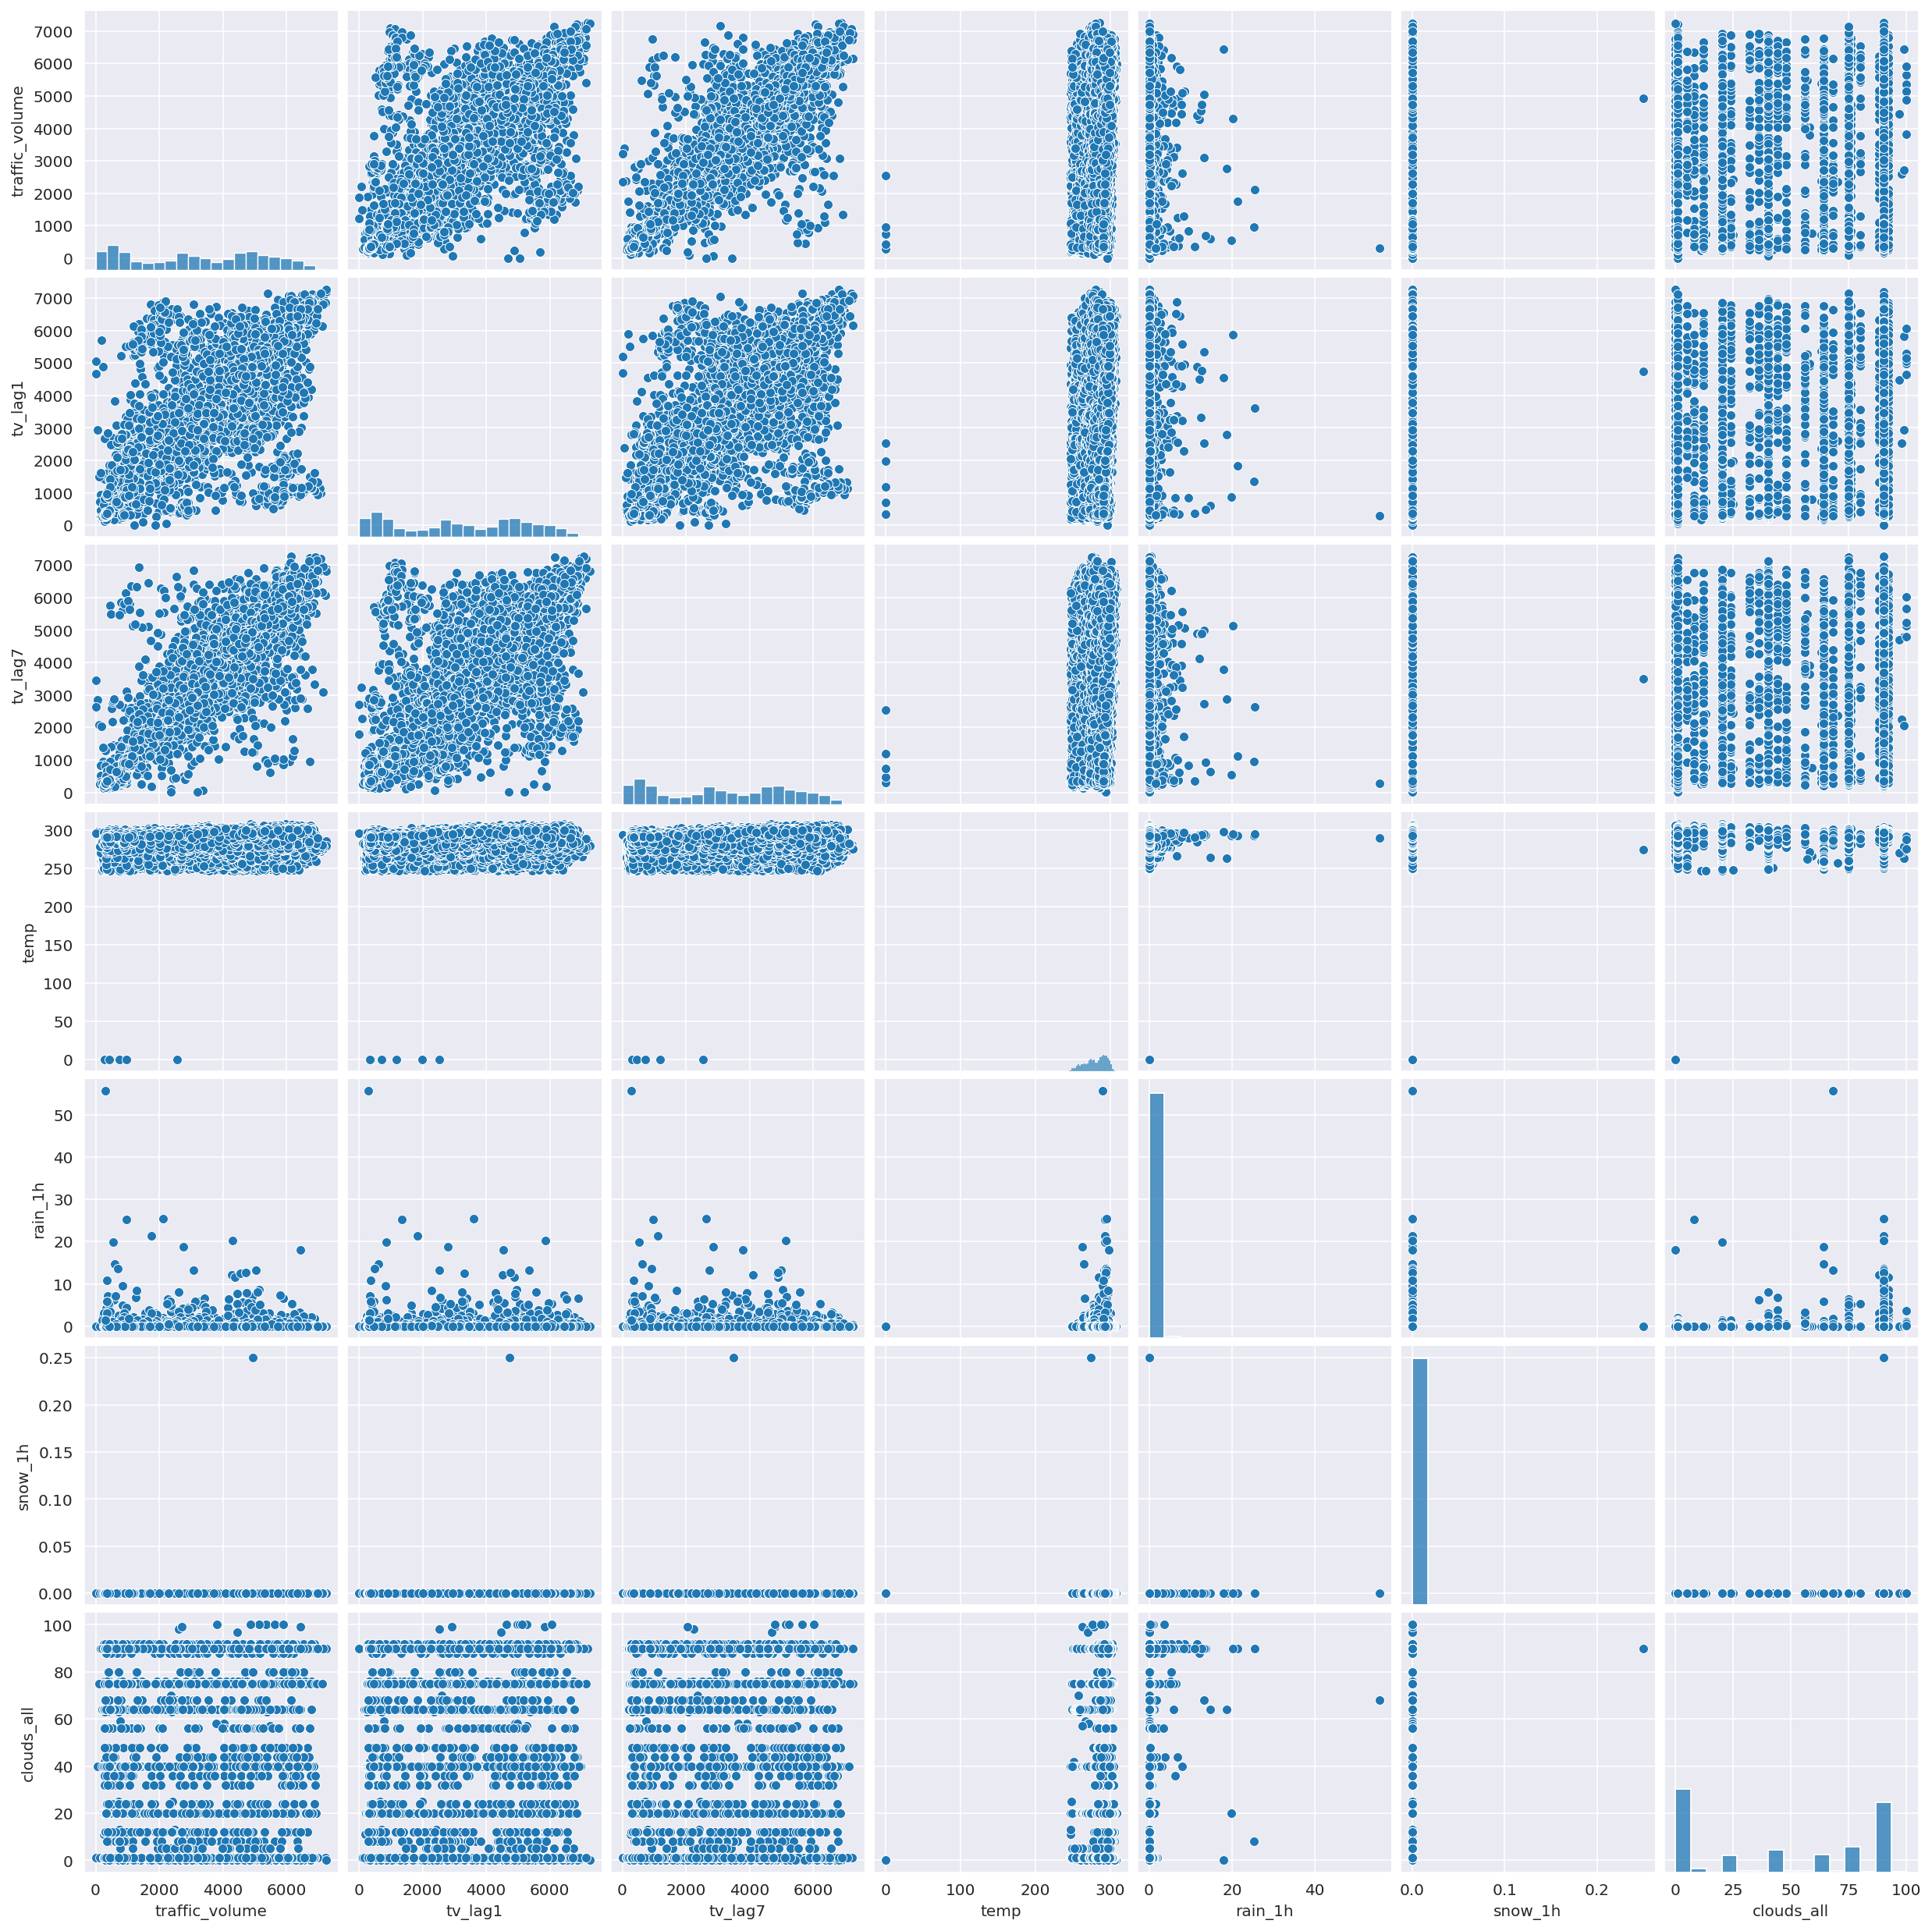

In [124]:
sns.pairplot(train_df.iloc[:24*365][[TARGET,'tv_lag1','tv_lag7','temp','rain_1h','snow_1h',"clouds_all"]])

In [181]:
preprocess_dict = {  }
train_df, one_hot_encoder_dict = one_hot_encoder(train_df,['weather'])
preprocess_dict['one_hot_enc_dict'] = one_hot_encoder_dict
test_df = preprocess_test(test_df,preprocess_dict)

In [154]:
feats

['temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'tv_lag1',
 'tv_lag7',
 'isnot_holiday',
 'day_of_week',
 'week_of_year',
 'weather_clear',
 'weather_heavy rain',
 'weather_light rain',
 'weather_mist',
 'weather_other',
 'weather_snow',
 'weather_thunder']

In [188]:
rf = RandomForestRegressor(random_state=42,oob_score=False,n_jobs=-1,bootstrap=False)
param_grid = {
    'n_estimators': [100,300],
    'max_depth': [4,8],
    'max_features': [0.5, 0.8],
    'min_samples_leaf': [5,11],
    'min_samples_split': [5,11,19],
}
best_rf_clf = parameter_search(train_df[feats].iloc[:365*24].values, 
                               train_df[TARGET].iloc[:365*24].values,
                               train_df[feats].iloc[365*24:365*48].values, 
                               train_df[TARGET].iloc[365*24:365*48].values,
                               estimator=rf,
                               param_grid=param_grid)             

best rmse: 339716.6898 and r2 is 0.917, and para is {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}


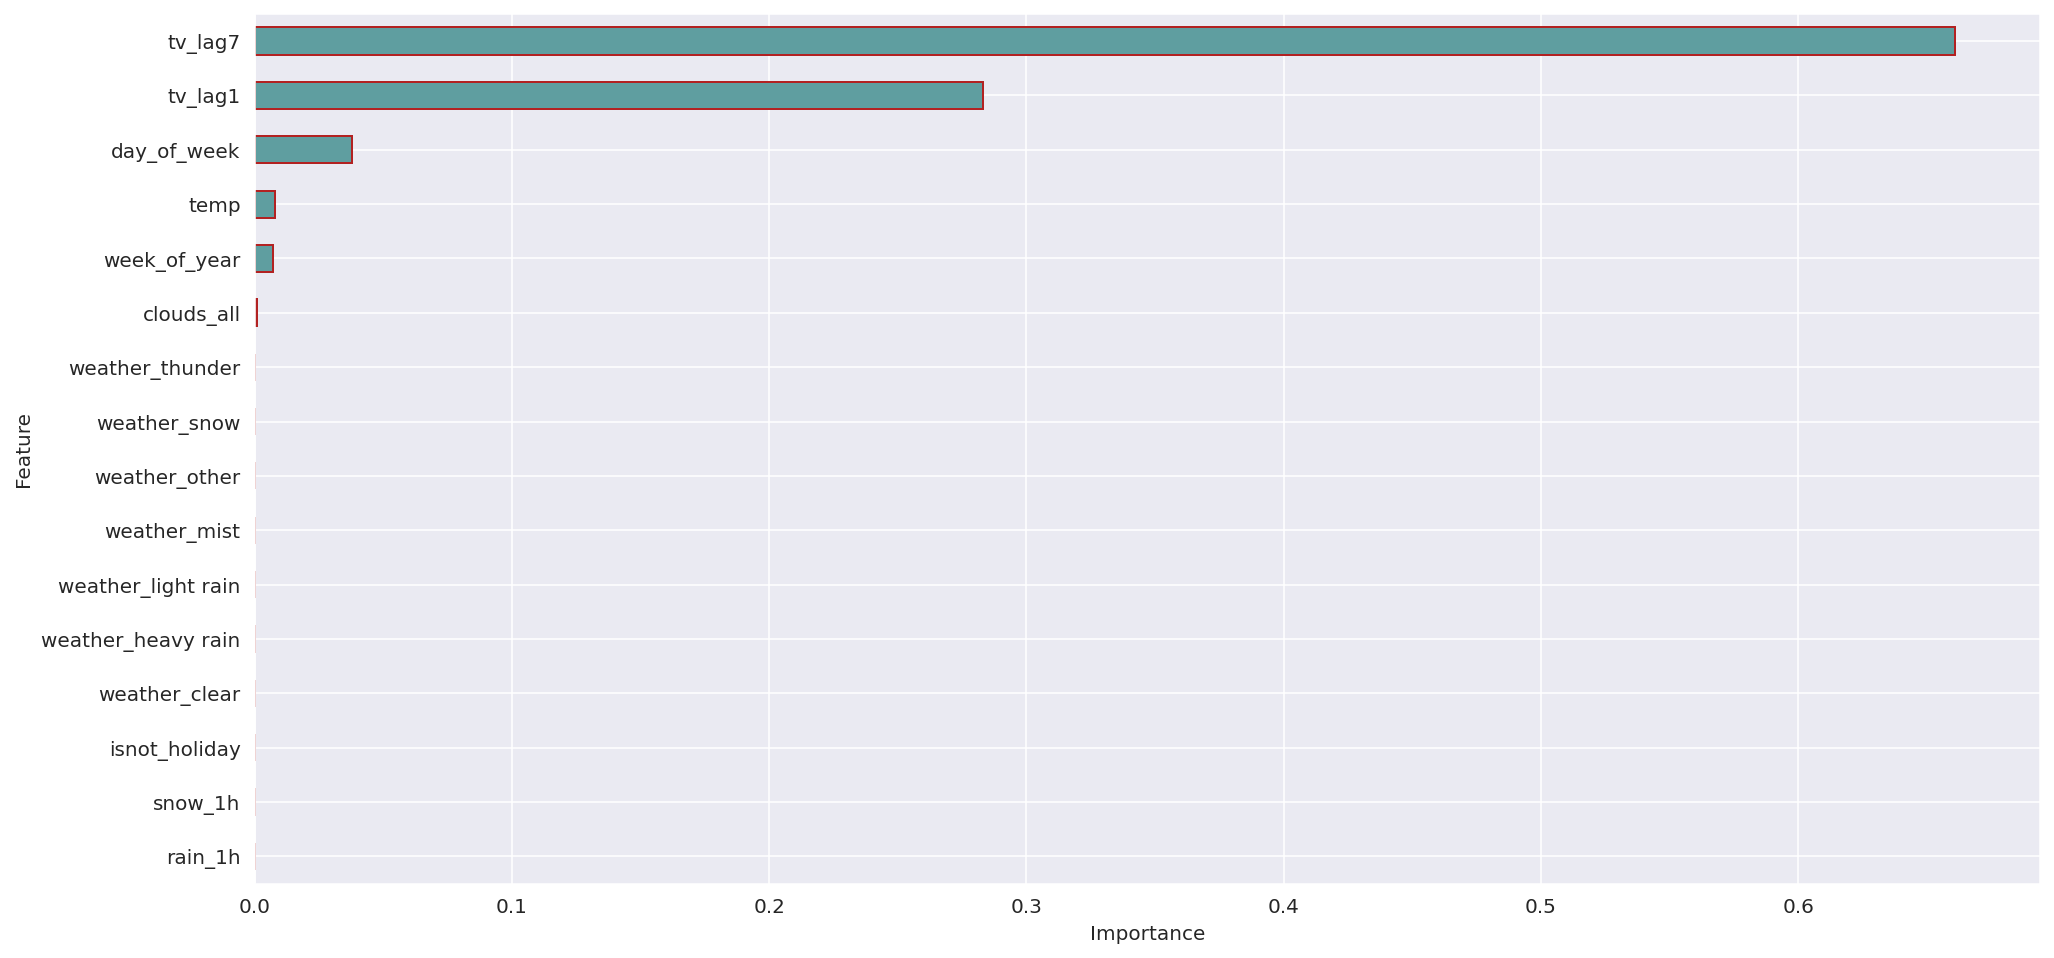

In [193]:
importances = plot_feature_imp(best_rf_clf,feats)

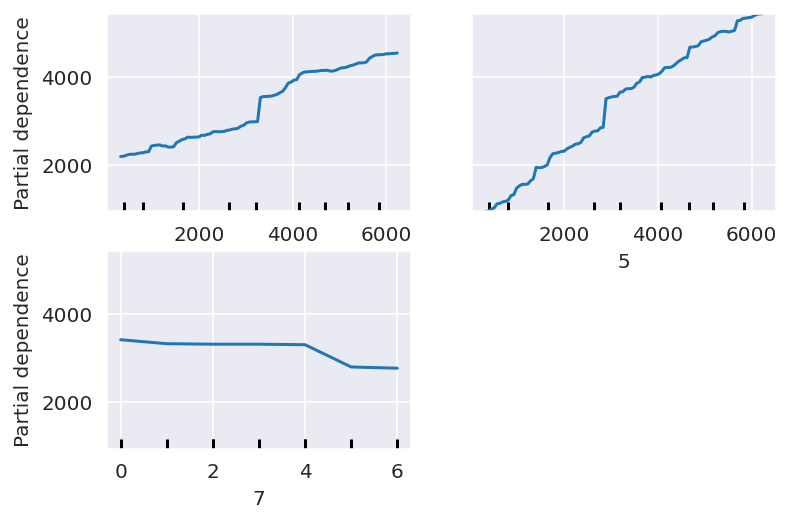

In [166]:

PartialDependenceDisplay.from_estimator(best_rf_clf, train_df.iloc[:365*24][feats].values, [4,5,7],n_cols=2)

In [186]:
pred_test = best_rf_clf.predict(test_df[feats].values)
print(f'test rmse is {((pred_test-test_df[TARGET])**2).mean():.2f}, r2 score is {r2_score(test_df[TARGET],pred_test):.3f}')

test rmse is 291806.85, rsq is 0.925


In [189]:
rf = RandomForestRegressor(random_state=42,oob_score=False,n_jobs=-1,bootstrap=False)
param_grid = {
    'n_estimators': [100,300],
    'max_depth': [4,8],
    'max_features': [0.5, 0.8],
    'min_samples_leaf': [5,11],
    'min_samples_split': [5,11,19],
}
less_feats = ['tv_lag1','tv_lag7','temp','day_of_week','week_of_year']
best_rf_clf_less_feat = parameter_search(train_df[less_feats].iloc[:365*24].values, 
                               train_df[TARGET].iloc[:365*24].values,
                               train_df[less_feats].iloc[365*24:365*48].values, 
                               train_df[TARGET].iloc[365*24:365*48].values,
                               estimator=rf,
                               param_grid=param_grid)             

best rmse: 341674.1000 and r2 is 0.916, and para is {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}


In [191]:
pred_test = best_rf_clf_less_feat.predict(test_df[less_feats].values)
print(f'test rmse is {((pred_test-test_df[TARGET])**2).mean():.2f}, r2 score is {r2_score(test_df[TARGET],pred_test):.3f}')

test rmse is 286347.24, r2 score is 0.927


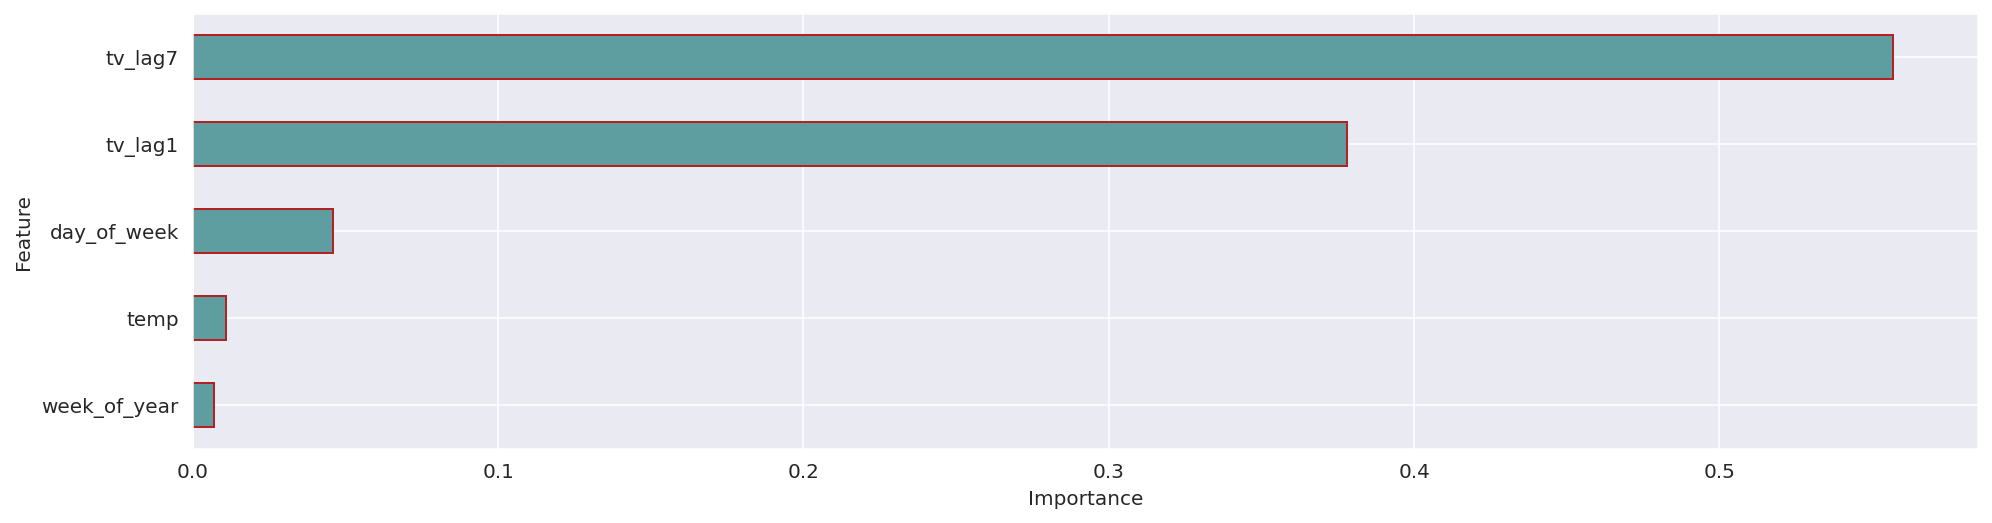

In [192]:
importances = plot_feature_imp(best_rf_clf_less_feat,less_feats)